In [1]:
import matplotlib.pyplot as plt
import numpy as np

import msiwarp as mx
from msiwarp.util.warp import peak_density_mz

# setup input and output filepaths
fdir = 'datasets/orbitrap-desi/'
imzml_path = fdir + 'A67 CT S4-centroid.imzML'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'

sigma_1 = 3.0e-7
epsilon = 1.0
slack = 2.0 * epsilon * sigma_1

mz_begin = 200
mz_end = 1000

In [2]:
import msiwarp as mx

from pyimzml.ImzMLParser import ImzMLParser
from msiwarp.util.warp import to_mx_peaks

positions = []
spectra = []

p = ImzMLParser(imzml_path)
for idx, coords in enumerate(p.coordinates):
    positions.append(coords)
    
    # 
    mzs, hs = p.getspectrum(idx)    
    spectra.append(to_mx_peaks(mzs, hs,
                               sigma_1, id = idx,
                               instrument_type = 'orbitrap'))

In [3]:
from msiwarp.util.warp import to_height
n_peaks = np.array([len(s) for s in spectra])
tic = np.array([np.sum(to_height(s)) for s in spectra])

In [4]:
n_steps = 33
n_peaks = 30
max_n_nodes = 8

params = mx.node_params(mx.Instrument.Orbitrap,
                        n_steps,
                        n_peaks,
                        max_n_nodes,
                        mz_begin,
                        mz_end,
                        slack)

# --------- set reference spectrum ----------
i_r = np.argmax(tic)
s_ref = spectra[i_r]

In [5]:
import time

n_cores = 8

t0 = time.time()
warping_funcs = mx.find_optimal_warpings_uni(spectra, s_ref, params, epsilon, n_cores)
t1 = time.time()
print("found optimal warpings in {:0.2f} seconds".format(t1 - t0))

found optimal warpings in 76.91 seconds


819


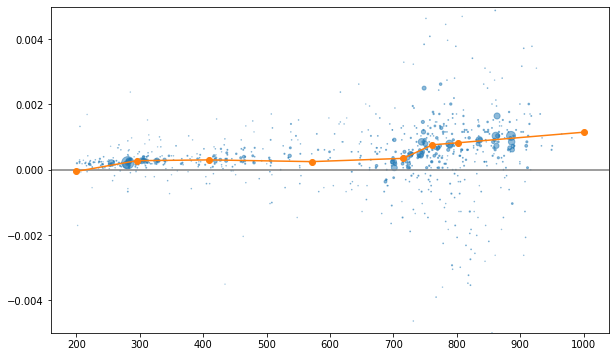

In [62]:
from msiwarp.util.warp import plot_peak_matches, plot_warping

i_s = np.random.choice(len(spectra))
s_s = spectra[i_s]

recal = warping_funcs[i_s]
xw = ([w[0] for w in recal])
yw = np.array([w[1] for w in recal])

pms = mx.overlapping_peak_pairs(s_ref, s_s, epsilon)
n_peak_matches = len(pms)
print(n_peak_matches)
    
_, ax = plt.subplots(figsize=(10,6))
ax.axhline(0, c='tab:gray')
plot_peak_matches(pms, 0.5, 150, ax=ax)
ax.plot(xw, -yw, '-o', c='tab:orange')
ax.set_ylim([-0.005, 0.005])
plt.show()

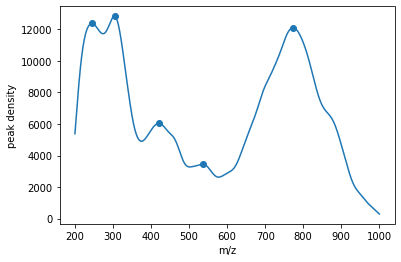

In [28]:
# warp spectra
xi = np.linspace(mz_begin, mz_end, 1000)
(yi, xp, yp) = peak_density_mz(spectra, xi, bandwidth=15, stride=100)

node_mzs = (xp[:-1] + xp[1:]) / 2
node_mzs = np.array([mz_begin, *node_mzs, mz_end])

# and we let the slack of the warping nodes increase with m/z like peak width
node_deltas = np.array([node_delta * mz ** (3/2)  for mz in node_mzs])
nodes = mx.initialize_nodes(node_mzs, node_deltas, n_steps)

#
_, ax = plt.subplots(figsize=(6,4))
ax.plot(xi, yi)
ax.scatter(xp, yp)
ax.set_ylabel('peak density')
ax.set_xlabel('m/z')
plt.show()

In [32]:
# choose a reference spectrum
i_r = 200
s_r = spectra[i_r]

print("warping spectra...")

import time
t0 = time.time()
optimal_moves = mx.find_optimal_spectra_warpings(spectra, s_r, nodes, epsilon)
t1 = time.time()
print("found optimal warpings in {:0.2f}s".format(t1 - t0))

t2 = time.time()
warped_spectra = [mx.warp_peaks(s_i, nodes, o_i) for (s_i, o_i) in zip(spectra, optimal_moves)]
t3 = time.time()
print("warped spectra in {:0.2f}s".format(t3 - t2))

warping spectra...
found optimal warpings in 77.72s
warped spectra in 7.11s


In [38]:
# save raw and warped data spectra in the MSI triplet format
if mx.spectra_to_triplets(fpath_triplets_raw, spectra):
    print("wrote raw MSI triplets to file")
    
if mx.spectra_to_triplets(fpath_triplets_warped, warped_spectra):
    print("wrote warped MSI triplets to file")

wrote raw MSI triplets to file
wrote warped MSI triplets to file


In [36]:
# convert back to pyimzml format

from pyimzml.ImzMLWriter import ImzMLWriter
from msiwarp.util.warp import to_mz, to_height

output_imzml = fdir + 'output.imzML'

with ImzMLWriter(output_imzml) as w:
    for s_i, coords in zip(warped_spectra, positions):
        # writes data to the .ibd file
        w.addSpectrum(to_mz(s_i), to_height(s_i), coords)

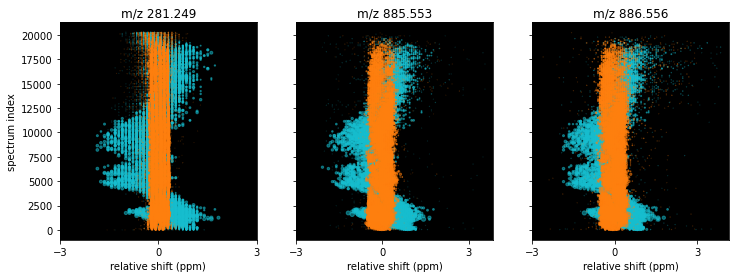

In [51]:
from msiwarp.util.warp import plot_range

mz_ref = np.sort(to_mz(mx.peaks_top_n(s_r, 3)))
mass_tolerance = 3

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ mass_tolerance around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax[i], 'tab:cyan', 25, in_ppm=True)
    plot_range(fpath_triplets_warped, mz0, mz1, ax[i], 'tab:orange', 25, in_ppm=True)
    
    ax[i].set_facecolor((0.0, 0.0, 0.0))
    ax[i].set_title('m/z {:0.3f}'.format(mz_i))
    ax[i].set_xticks([-mass_tolerance, 0, mass_tolerance])
    ax[i].set_xlabel('relative shift (ppm)')
    
ax[0].set_ylabel('spectrum index')
plt.show()